In [1]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'

In [29]:
#Step 1: Import Data from Source Link
data_link = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00458/Roman%20Urdu%20DataSet.csv'
Raw_Data = pd.read_csv(data_link)
Raw_Data.head(2)

,Sai kha ya her kisi kay bus ki bat nhi hai lakin main ki hal kal bi Aj aur aj bi sirf Aus say bus,Positive,Unnamed: 2
0,sahi bt h,Positive,NaN
1,"Kya bt hai,",Positive,NaN


In [30]:
# Step 2: Add variable names becuase raw data was missing variable names.
Raw_Data = pd.read_csv(data_link , names=["Customer_Comment", "Sentiment_Classifier", "Flag"])
Raw_Data.head(2)

,Customer_Comment,Sentiment_Classifier,Flag
0,Sai kha ya her kisi kay bus ki bat nhi hai lak...,Positive,NaN
1,sahi bt h,Positive,NaN


In [31]:
Raw_Data.groupby("Flag")["Flag"].count()

Flag
------              1
-------             1
----------          1
----------------    1
9090                1
till here           2
Name: Flag, dtype: int64

In [32]:
## Removed Flag field, looks like it is an extraneous variable as per the business objective.
Raw_Data_1 = Raw_Data[["Customer_Comment", "Sentiment_Classifier"]]
Raw_Data_1.head(2)

,Customer_Comment,Sentiment_Classifier
0,Sai kha ya her kisi kay bus ki bat nhi hai lak...,Positive
1,sahi bt h,Positive


In [33]:
#Examine Sentiment Classifier field
Raw_Data_1.groupby("Sentiment_Classifier")["Sentiment_Classifier"].count()

Sentiment_Classifier
Neative        1
Negative    5286
Neutral     8929
Positive    6013
Name: Sentiment_Classifier, dtype: int64

In [34]:
#Clean 'Neative' value from above to 'Negative'
Raw_Data_1['Sentiment_Classifier'] = Raw_Data_1['Sentiment_Classifier'].replace('Neative', 'Negative')
Raw_Data_1.head(2)

,Customer_Comment,Sentiment_Classifier
0,Sai kha ya her kisi kay bus ki bat nhi hai lak...,Positive
1,sahi bt h,Positive


In [35]:
# Validate Data
Raw_Data_1.groupby("Sentiment_Classifier")["Sentiment_Classifier"].count()

Sentiment_Classifier
Negative    5287
Neutral     8929
Positive    6013
Name: Sentiment_Classifier, dtype: int64

In [81]:
# Change from 3 classes to 2 by assigning 1 to Negative values and 0 to positive and neutral values
Raw_Data_1["Sentiment_Classifier"] = Raw_Data_1["Sentiment_Classifier"].map({'Negative': 2, 'Positive': 1, 'Neutral':0})

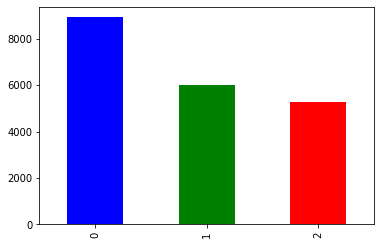

In [82]:
# Visualize Data
import matplotlib.pyplot as plt
Raw_Data_1['Sentiment_Classifier'].value_counts().plot(kind='bar' ,color=['blue', 'green', 'red'])

In [83]:
# Confirm if there is missing Data
print(Raw_Data_1.isnull().sum())

Customer_Comment        1
Sentiment_Classifier    0
dtype: int64


In [84]:
##This shows that there is at least one within Customer_Comment field, so let remove them.
Raw_Data_2 = Raw_Data_1[pd.notnull(Raw_Data_1["Customer_Comment"])]
Raw_Data_2.head()

,Customer_Comment,Sentiment_Classifier
0,Sai kha ya her kisi kay bus ki bat nhi hai lak...,1
1,sahi bt h,1
2,"Kya bt hai,",1
3,Wah je wah,1
4,Are wha kaya bat hai,1


In [85]:
# Confirm if there is missing Data
print(Raw_Data_2.isnull().sum())

Customer_Comment        0
Sentiment_Classifier    0
dtype: int64


In [86]:
# Convert data to lower case, trim leading and trailing white spaces.
# lower case
Raw_Data_2['Customer_Comment'] = Raw_Data_2['Customer_Comment'].str.lower()
Raw_Data_2.head(2)

,Customer_Comment,Sentiment_Classifier
0,sai kha ya her kisi kay bus ki bat nhi hai lak...,1
1,sahi bt h,1


In [87]:
#trim leading and trailing white spaces
Raw_Data_2 = Raw_Data_2.applymap(lambda x: x.strip() if isinstance(x, str) else x)
Raw_Data_2.head(2)

,Customer_Comment,Sentiment_Classifier
0,sai kha ya her kisi kay bus ki bat nhi hai lak...,1
1,sahi bt h,1


# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [16]:
import tensorflow
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, Dense, Dropout, Embedding, GlobalMaxPool1D, LSTM, Flatten, SimpleRNN, GRU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [88]:
# Convert Sentiment_Classifier values to integers
Raw_Data_2['Sentiment_Classifier'] = Raw_Data_2.Sentiment_Classifier.astype('category').cat.codes
Raw_Data_2.head(2)

,Customer_Comment,Sentiment_Classifier
0,sai kha ya her kisi kay bus ki bat nhi hai lak...,1
1,sahi bt h,1


In [89]:
# For a deep learning model we need to know what the input sequence length for our model should be
# Calculate the number of words in the Customer_Comment column and find the maximum value to be used for input sequence

Raw_Data_2['num_words'] = Raw_Data_2.Customer_Comment.apply(lambda x : len(x.split()))

Raw_Data_2['num_words'].max()

301

In [90]:
# Set number of classes and target variable
num_class = len(np.unique(Raw_Data_2.Sentiment_Classifier.values))
y = Raw_Data_2['Sentiment_Classifier'].values
print(num_class)

3


In [91]:
#Tokenize the input and pad
maxlen = 302
tokenizer = tensorflow.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(Raw_Data_2.Customer_Comment.values)
post_seq = tokenizer.texts_to_sequences(Raw_Data_2.Customer_Comment.values)
post_seq_padded = pad_sequences(post_seq, maxlen=maxlen)

In [92]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

33269


In [93]:
# Creating a train test split with 30% in testing data set
x_train, x_test, y_train, y_test = train_test_split(post_seq_padded, y, test_size=0.30)

# A : Simple RNN

In [104]:
# Build Model
embedding_vector_length = 32 
model = Sequential() 
model.add(Embedding(vocab_size, 
                    embedding_vector_length, 
                    input_length = maxlen))
model.add(SimpleRNN(256))
model.add(Dense(3, activation='softmax'))

In [105]:
# Compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 302, 32)           1064608   
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 256)               73984     
                                                                 
 dense_8 (Dense)             (None, 3)                 771       
                                                                 
Total params: 1,139,363
Trainable params: 1,139,363
Non-trainable params: 0
_________________________________________________________________
None


In [98]:
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [99]:
y_train.shape

(14159, 3)

In [100]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5, batch_size=64)

Epoch 1/5
222/222 [==============================] - 68s 303ms/step - loss: 1.1126 - accuracy: 0.4017 - val_loss: 1.0608 - val_accuracy: 0.4564
Epoch 2/5
222/222 [==============================] - 67s 301ms/step - loss: 1.0238 - accuracy: 0.4803 - val_loss: 1.0920 - val_accuracy: 0.4564
Epoch 3/5
222/222 [==============================] - 69s 311ms/step - loss: 1.0142 - accuracy: 0.4897 - val_loss: 0.9954 - val_accuracy: 0.4961
Epoch 4/5
222/222 [==============================] - 71s 318ms/step - loss: 0.7866 - accuracy: 0.6574 - val_loss: 0.9693 - val_accuracy: 0.5301
Epoch 5/5
222/222 [==============================] - 68s 308ms/step - loss: 0.5399 - accuracy: 0.7897 - val_loss: 0.9787 - val_accuracy: 0.6006


In [101]:
loss, metric = model.evaluate(x_test, y_test, verbose=0)
print("Test accuracy: %0.3f" % metric)

Test accuracy: 0.601


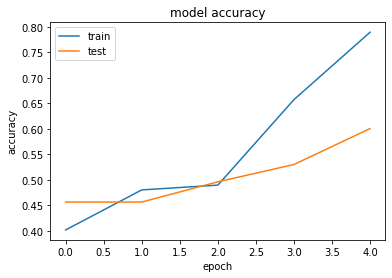

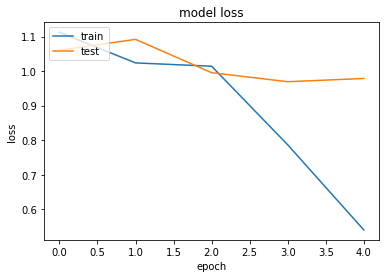

In [102]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# B : More Simple RNN without Dropout
 

In [116]:
# Build Model
embedding_vector_length = 32 
model = Sequential() 
model.add(Embedding(vocab_size, 
                    embedding_vector_length, 
                    input_length = maxlen))
model.add(SimpleRNN(256,return_sequences=True))
model.add(SimpleRNN(128))
model.add(Dense(3, activation='softmax'))

In [117]:
# Compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 302, 32)           1064608   
                                                                 
 simple_rnn_16 (SimpleRNN)   (None, 302, 256)          73984     
                                                                 
 simple_rnn_17 (SimpleRNN)   (None, 128)               49280     
                                                                 
 dense_11 (Dense)            (None, 3)                 387       
                                                                 
Total params: 1,188,259
Trainable params: 1,188,259
Non-trainable params: 0
_________________________________________________________________
None


In [118]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5, batch_size=64)

Epoch 1/5
222/222 [==============================] - 144s 643ms/step - loss: 1.1463 - accuracy: 0.3969 - val_loss: 1.0735 - val_accuracy: 0.4455
Epoch 2/5
222/222 [==============================] - 136s 612ms/step - loss: 1.0763 - accuracy: 0.4396 - val_loss: 1.0736 - val_accuracy: 0.4455
Epoch 3/5
222/222 [==============================] - 134s 604ms/step - loss: 1.0772 - accuracy: 0.4366 - val_loss: 1.0716 - val_accuracy: 0.4455
Epoch 4/5
222/222 [==============================] - 134s 606ms/step - loss: 1.0781 - accuracy: 0.4344 - val_loss: 1.0712 - val_accuracy: 0.4455
Epoch 5/5
222/222 [==============================] - 133s 601ms/step - loss: 1.0775 - accuracy: 0.4352 - val_loss: 1.0798 - val_accuracy: 0.4455


In [119]:
loss, metric = model.evaluate(x_test, y_test, verbose=0)
print("Test accuracy: %0.3f" % metric)

Test accuracy: 0.446


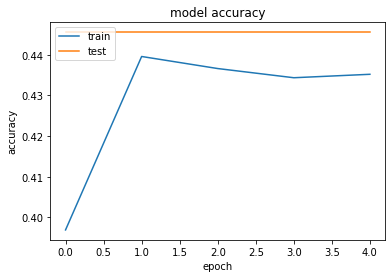

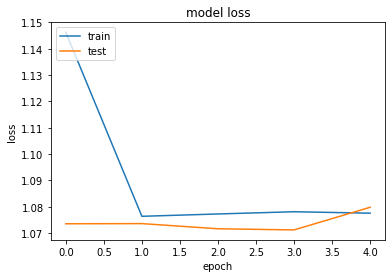

In [120]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# B : More Simple RNN with Dropout

In [126]:
# Build Model
embedding_vector_length = 32 
model = Sequential() 
model.add(Embedding(vocab_size, 
                    embedding_vector_length, 
                    input_length = maxlen))
model.add(SimpleRNN(128,return_sequences=True))
model.add(Dropout(0.2))
model.add(SimpleRNN(64))
model.add(Dense(3, activation='softmax'))

In [127]:
# Compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 302, 32)           1064608   
                                                                 
 simple_rnn_22 (SimpleRNN)   (None, 302, 128)          20608     
                                                                 
 dropout_2 (Dropout)         (None, 302, 128)          0         
                                                                 
 simple_rnn_23 (SimpleRNN)   (None, 64)                12352     
                                                                 
 dense_14 (Dense)            (None, 3)                 195       
                                                                 
Total params: 1,097,763
Trainable params: 1,097,763
Non-trainable params: 0
_________________________________________________________________
None


In [128]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5, batch_size=64)

Epoch 1/5
222/222 [==============================] - 167s 748ms/step - loss: 1.0906 - accuracy: 0.4161 - val_loss: 1.0626 - val_accuracy: 0.4447
Epoch 2/5
222/222 [==============================] - 122s 548ms/step - loss: 1.0158 - accuracy: 0.4897 - val_loss: 0.9555 - val_accuracy: 0.5352
Epoch 3/5
222/222 [==============================] - 119s 538ms/step - loss: 0.8185 - accuracy: 0.6277 - val_loss: 0.9964 - val_accuracy: 0.5589
Epoch 4/5
222/222 [==============================] - 120s 541ms/step - loss: 0.5623 - accuracy: 0.7696 - val_loss: 1.2299 - val_accuracy: 0.5487
Epoch 5/5
222/222 [==============================] - 123s 552ms/step - loss: 0.5976 - accuracy: 0.7486 - val_loss: 1.2516 - val_accuracy: 0.5400


In [129]:
loss, metric = model.evaluate(x_test, y_test, verbose=0)
print("Test accuracy: %0.3f" % metric)

Test accuracy: 0.540


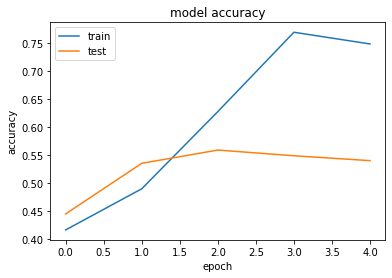

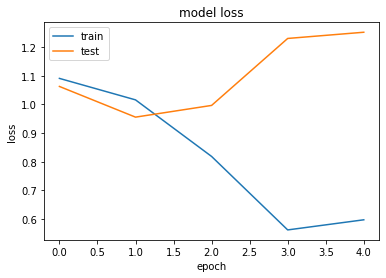

In [130]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# C: LSTM

In [131]:
# Build Model
embedding_vector_length = 32 
model = Sequential() 
model.add(Embedding(vocab_size, 
                    embedding_vector_length, 
                    input_length = maxlen))
model.add(LSTM(256))
model.add(Dense(3, activation='softmax'))

In [132]:
# Compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 302, 32)           1064608   
                                                                 
 lstm (LSTM)                 (None, 256)               295936    
                                                                 
 dense_15 (Dense)            (None, 3)                 771       
                                                                 
Total params: 1,361,315
Trainable params: 1,361,315
Non-trainable params: 0
_________________________________________________________________
None


In [133]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5, batch_size=64)

Epoch 1/5
222/222 [==============================] - 12s 30ms/step - loss: 0.9827 - accuracy: 0.5171 - val_loss: 0.8853 - val_accuracy: 0.5932
Epoch 2/5
222/222 [==============================] - 6s 28ms/step - loss: 0.6738 - accuracy: 0.7236 - val_loss: 0.8421 - val_accuracy: 0.6459
Epoch 3/5
222/222 [==============================] - 6s 28ms/step - loss: 0.3699 - accuracy: 0.8625 - val_loss: 1.0312 - val_accuracy: 0.6375
Epoch 4/5
222/222 [==============================] - 6s 28ms/step - loss: 0.1977 - accuracy: 0.9341 - val_loss: 1.3022 - val_accuracy: 0.6253
Epoch 5/5
222/222 [==============================] - 6s 28ms/step - loss: 0.1182 - accuracy: 0.9619 - val_loss: 1.4475 - val_accuracy: 0.6214


In [134]:
loss, metric = model.evaluate(x_test, y_test, verbose=0)
print("Test accuracy: %0.3f" % metric)

Test accuracy: 0.621


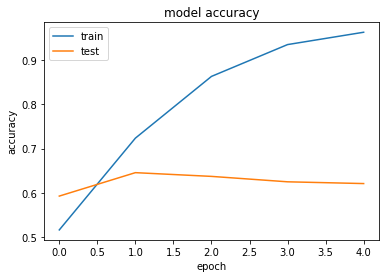

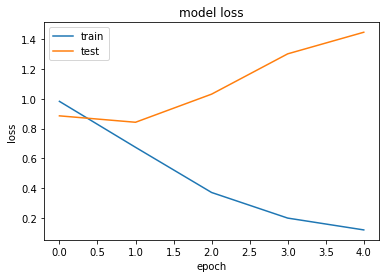

In [135]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# C: multi layer LSTM

In [136]:
# Build Model
embedding_vector_length = 32 
model = Sequential() 
model.add(Embedding(vocab_size, 
                    embedding_vector_length, 
                    input_length = maxlen))
model.add(LSTM(256,return_sequences=True))
model.add(LSTM(128))
model.add(Dense(3, activation='softmax'))

In [137]:
# Compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 302, 32)           1064608   
                                                                 
 lstm_1 (LSTM)               (None, 302, 256)          295936    
                                                                 
 lstm_2 (LSTM)               (None, 128)               197120    
                                                                 
 dense_16 (Dense)            (None, 3)                 387       
                                                                 
Total params: 1,558,051
Trainable params: 1,558,051
Non-trainable params: 0
_________________________________________________________________
None


In [138]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5, batch_size=64)

Epoch 1/5
222/222 [==============================] - 15s 51ms/step - loss: 0.9769 - accuracy: 0.5134 - val_loss: 0.8665 - val_accuracy: 0.6186
Epoch 2/5
222/222 [==============================] - 11s 48ms/step - loss: 0.6330 - accuracy: 0.7445 - val_loss: 0.8529 - val_accuracy: 0.6436
Epoch 3/5
222/222 [==============================] - 10s 47ms/step - loss: 0.3232 - accuracy: 0.8845 - val_loss: 1.0402 - val_accuracy: 0.6388
Epoch 4/5
222/222 [==============================] - 10s 47ms/step - loss: 0.1740 - accuracy: 0.9419 - val_loss: 1.1841 - val_accuracy: 0.6306
Epoch 5/5
222/222 [==============================] - 11s 51ms/step - loss: 0.1125 - accuracy: 0.9641 - val_loss: 1.3728 - val_accuracy: 0.6344


In [139]:
loss, metric = model.evaluate(x_test, y_test, verbose=0)
print("Test accuracy: %0.3f" % metric)

Test accuracy: 0.634


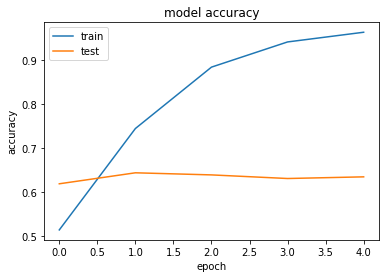

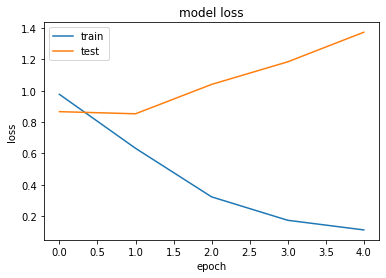

In [140]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# C: multi layer LSTM + Dropout

In [141]:
# Build Model
embedding_vector_length = 32 
model = Sequential() 
model.add(Embedding(vocab_size, 
                    embedding_vector_length, 
                    input_length = maxlen))
model.add(LSTM(256,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dense(3, activation='softmax'))

In [142]:
# Compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 302, 32)           1064608   
                                                                 
 lstm_3 (LSTM)               (None, 302, 256)          295936    
                                                                 
 dropout_3 (Dropout)         (None, 302, 256)          0         
                                                                 
 lstm_4 (LSTM)               (None, 128)               197120    
                                                                 
 dense_17 (Dense)            (None, 3)                 387       
                                                                 
Total params: 1,558,051
Trainable params: 1,558,051
Non-trainable params: 0
_________________________________________________________________
None


In [143]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5, batch_size=64)

Epoch 1/5
222/222 [==============================] - 15s 51ms/step - loss: 0.9816 - accuracy: 0.5213 - val_loss: 0.8619 - val_accuracy: 0.6153
Epoch 2/5
222/222 [==============================] - 11s 48ms/step - loss: 0.6304 - accuracy: 0.7471 - val_loss: 0.8400 - val_accuracy: 0.6504
Epoch 3/5
222/222 [==============================] - 11s 48ms/step - loss: 0.3279 - accuracy: 0.8831 - val_loss: 1.0012 - val_accuracy: 0.6375
Epoch 4/5
222/222 [==============================] - 11s 48ms/step - loss: 0.1745 - accuracy: 0.9403 - val_loss: 1.2168 - val_accuracy: 0.6260
Epoch 5/5
222/222 [==============================] - 11s 48ms/step - loss: 0.1136 - accuracy: 0.9643 - val_loss: 1.4512 - val_accuracy: 0.6352


In [144]:
loss, metric = model.evaluate(x_test, y_test, verbose=0)
print("Test accuracy: %0.3f" % metric)

Test accuracy: 0.635


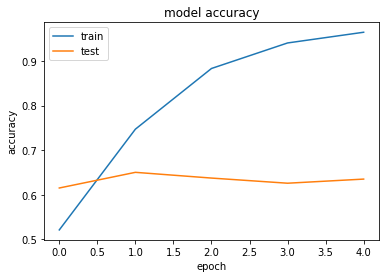

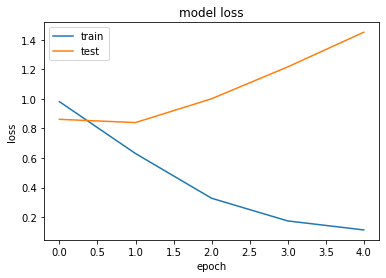

In [145]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# C: GRU

In [148]:
# Build Model
embedding_vector_length = 32 
model = Sequential() 
model.add(Embedding(vocab_size, 
                    embedding_vector_length, 
                    input_length = maxlen))
model.add(GRU(256))
model.add(Dense(3, activation='softmax'))

In [149]:
# Compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 302, 32)           1064608   
                                                                 
 gru (GRU)                   (None, 256)               222720    
                                                                 
 dense_18 (Dense)            (None, 3)                 771       
                                                                 
Total params: 1,288,099
Trainable params: 1,288,099
Non-trainable params: 0
_________________________________________________________________
None


In [150]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5, batch_size=64)

Epoch 1/5
222/222 [==============================] - 9s 32ms/step - loss: 0.9715 - accuracy: 0.5201 - val_loss: 0.8432 - val_accuracy: 0.6304
Epoch 2/5
222/222 [==============================] - 6s 29ms/step - loss: 0.6145 - accuracy: 0.7510 - val_loss: 0.8321 - val_accuracy: 0.6398
Epoch 3/5
222/222 [==============================] - 7s 31ms/step - loss: 0.3134 - accuracy: 0.8876 - val_loss: 1.0680 - val_accuracy: 0.6335
Epoch 4/5
222/222 [==============================] - 6s 26ms/step - loss: 0.1728 - accuracy: 0.9416 - val_loss: 1.2772 - val_accuracy: 0.6194
Epoch 5/5
222/222 [==============================] - 7s 30ms/step - loss: 0.1028 - accuracy: 0.9666 - val_loss: 1.5557 - val_accuracy: 0.6210


In [151]:
loss, metric = model.evaluate(x_test, y_test, verbose=0)
print("Test accuracy: %0.3f" % metric)

Test accuracy: 0.621


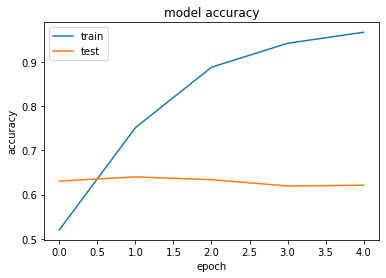

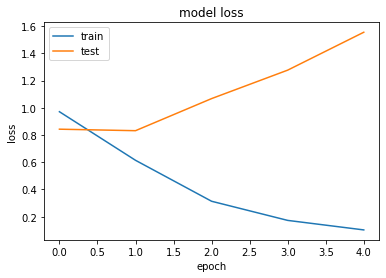

In [152]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# C: Multi layer GRU

In [159]:
# Build Model
embedding_vector_length = 32 
model = Sequential() 
model.add(Embedding(vocab_size, 
                    embedding_vector_length, 
                    input_length = maxlen))
model.add(GRU(256,return_sequences=True))
model.add(GRU(128))
model.add(Dense(3, activation='softmax'))

In [160]:
# Compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 302, 32)           1064608   
                                                                 
 gru_3 (GRU)                 (None, 302, 256)          222720    
                                                                 
 gru_4 (GRU)                 (None, 128)               148224    
                                                                 
 dense_20 (Dense)            (None, 3)                 387       
                                                                 
Total params: 1,435,939
Trainable params: 1,435,939
Non-trainable params: 0
_________________________________________________________________
None


In [161]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5, batch_size=64)

Epoch 1/5
222/222 [==============================] - 13s 45ms/step - loss: 0.9419 - accuracy: 0.5432 - val_loss: 0.8560 - val_accuracy: 0.6121
Epoch 2/5
222/222 [==============================] - 9s 42ms/step - loss: 0.5644 - accuracy: 0.7717 - val_loss: 0.8362 - val_accuracy: 0.6431
Epoch 3/5
222/222 [==============================] - 10s 45ms/step - loss: 0.2698 - accuracy: 0.9045 - val_loss: 1.0814 - val_accuracy: 0.6228
Epoch 4/5
222/222 [==============================] - 10s 43ms/step - loss: 0.1420 - accuracy: 0.9504 - val_loss: 1.4923 - val_accuracy: 0.6197
Epoch 5/5
222/222 [==============================] - 9s 43ms/step - loss: 0.0935 - accuracy: 0.9689 - val_loss: 1.5682 - val_accuracy: 0.6210


In [162]:
loss, metric = model.evaluate(x_test, y_test, verbose=0)
print("Test accuracy: %0.3f" % metric)

Test accuracy: 0.621


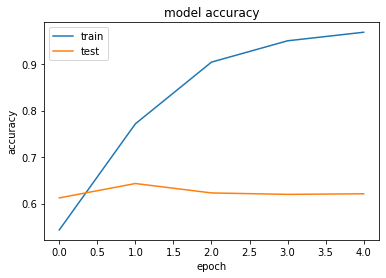

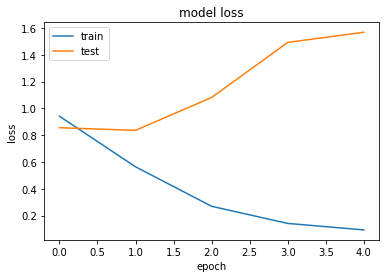

In [163]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

C: Multi layer GRU + Dropout

In [164]:
# Build Model
embedding_vector_length = 32 
model = Sequential() 
model.add(Embedding(vocab_size, 
                    embedding_vector_length, 
                    input_length = maxlen))
model.add(GRU(256,return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(128))
model.add(Dense(3, activation='softmax'))

In [165]:
# Compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 302, 32)           1064608   
                                                                 
 gru_5 (GRU)                 (None, 302, 256)          222720    
                                                                 
 dropout_4 (Dropout)         (None, 302, 256)          0         
                                                                 
 gru_6 (GRU)                 (None, 128)               148224    
                                                                 
 dense_21 (Dense)            (None, 3)                 387       
                                                                 
Total params: 1,435,939
Trainable params: 1,435,939
Non-trainable params: 0
_________________________________________________________________
None


In [166]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5, batch_size=64)

Epoch 1/5
222/222 [==============================] - 15s 54ms/step - loss: 0.9360 - accuracy: 0.5488 - val_loss: 0.8702 - val_accuracy: 0.6144
Epoch 2/5
222/222 [==============================] - 10s 45ms/step - loss: 0.5535 - accuracy: 0.7825 - val_loss: 0.8836 - val_accuracy: 0.6418
Epoch 3/5
222/222 [==============================] - 10s 44ms/step - loss: 0.2712 - accuracy: 0.9027 - val_loss: 1.0835 - val_accuracy: 0.6230
Epoch 4/5
222/222 [==============================] - 10s 44ms/step - loss: 0.1405 - accuracy: 0.9531 - val_loss: 1.4017 - val_accuracy: 0.6283
Epoch 5/5
222/222 [==============================] - 10s 44ms/step - loss: 0.0832 - accuracy: 0.9737 - val_loss: 1.5825 - val_accuracy: 0.6146


In [167]:
loss, metric = model.evaluate(x_test, y_test, verbose=0)
print("Test accuracy: %0.3f" % metric)

Test accuracy: 0.615


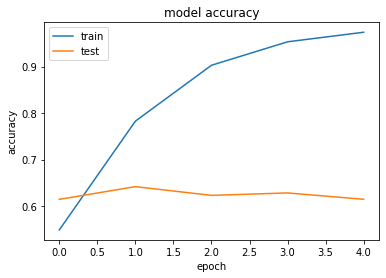

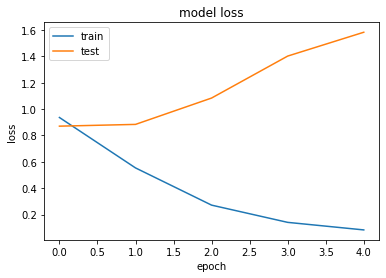

In [168]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# D: Improve results


## Way 1
Convet 2 1 0 to -1 1 0 for Negative, Positive, and Neutral respectively. 
### improvement: 2% - 3%

In [9]:
Raw_Data_1["Sentiment_Classifier"] = Raw_Data_1["Sentiment_Classifier"].map({'Negative': -1, 'Positive': 1, 'Neutral':0})

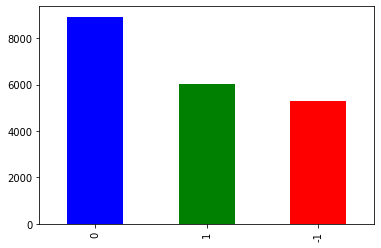

In [10]:
# Visualize Data
import matplotlib.pyplot as plt
Raw_Data_1['Sentiment_Classifier'].value_counts().plot(kind='bar' ,color=['blue', 'green', 'red'])

In [11]:
# Confirm if there is missing Data
print(Raw_Data_1.isnull().sum())

Customer_Comment        1
Sentiment_Classifier    0
dtype: int64


In [12]:
##This shows that there is at least one within Customer_Comment field, so let remove them.
Raw_Data_2 = Raw_Data_1[pd.notnull(Raw_Data_1["Customer_Comment"])]
Raw_Data_2.head()

,Customer_Comment,Sentiment_Classifier
0,Sai kha ya her kisi kay bus ki bat nhi hai lak...,1
1,sahi bt h,1
2,"Kya bt hai,",1
3,Wah je wah,1
4,Are wha kaya bat hai,1


In [13]:
# Confirm if there is missing Data
print(Raw_Data_2.isnull().sum())

Customer_Comment        0
Sentiment_Classifier    0
dtype: int64


In [14]:
# Convert data to lower case, trim leading and trailing white spaces.
# lower case
Raw_Data_2['Customer_Comment'] = Raw_Data_2['Customer_Comment'].str.lower()
Raw_Data_2.head(2)

,Customer_Comment,Sentiment_Classifier
0,sai kha ya her kisi kay bus ki bat nhi hai lak...,1
1,sahi bt h,1


In [15]:
#trim leading and trailing white spaces
Raw_Data_2 = Raw_Data_2.applymap(lambda x: x.strip() if isinstance(x, str) else x)
Raw_Data_2.head(2)

,Customer_Comment,Sentiment_Classifier
0,sai kha ya her kisi kay bus ki bat nhi hai lak...,1
1,sahi bt h,1


In [17]:
# Convert Sentiment_Classifier values to integers
Raw_Data_2['Sentiment_Classifier'] = Raw_Data_2.Sentiment_Classifier.astype('category').cat.codes
Raw_Data_2.head(2)

,Customer_Comment,Sentiment_Classifier
0,sai kha ya her kisi kay bus ki bat nhi hai lak...,2
1,sahi bt h,2


In [18]:
# For a deep learning model we need to know what the input sequence length for our model should be
# Calculate the number of words in the Customer_Comment column and find the maximum value to be used for input sequence

Raw_Data_2['num_words'] = Raw_Data_2.Customer_Comment.apply(lambda x : len(x.split()))

Raw_Data_2['num_words'].max()

301

In [19]:
# Set number of classes and target variable
num_class = len(np.unique(Raw_Data_2.Sentiment_Classifier.values))
y = Raw_Data_2['Sentiment_Classifier'].values
print(num_class)

3


In [20]:
#Tokenize the input and pad
maxlen = 302
tokenizer = tensorflow.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(Raw_Data_2.Customer_Comment.values)
post_seq = tokenizer.texts_to_sequences(Raw_Data_2.Customer_Comment.values)
post_seq_padded = pad_sequences(post_seq, maxlen=maxlen)

In [21]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

33269


In [22]:
# Creating a train test split with 30% in testing data set
x_train, x_test, y_train, y_test = train_test_split(post_seq_padded, y, test_size=0.30)

In [23]:
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [24]:
# Model
# Build Model
embedding_vector_length = 32 
model = Sequential() 
model.add(Embedding(vocab_size, 
                    embedding_vector_length, 
                    input_length = maxlen))
model.add(LSTM(256,return_sequences=True))
model.add(LSTM(128))
model.add(Dense(3, activation='softmax'))

In [25]:
# Compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 302, 32)           1064608   
                                                                 
 lstm (LSTM)                 (None, 302, 256)          295936    
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 1,558,051
Trainable params: 1,558,051
Non-trainable params: 0
_________________________________________________________________
None


In [28]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5, batch_size=64)

Epoch 1/5
222/222 [==============================] - 47s 168ms/step - loss: 0.9464 - accuracy: 0.6274 - val_loss: 0.8078 - val_accuracy: 0.7303
Epoch 2/5
222/222 [==============================] - 36s 163ms/step - loss: 0.5776 - accuracy: 0.8735 - val_loss: 0.8559 - val_accuracy: 0.7471
Epoch 3/5
222/222 [==============================] - 36s 162ms/step - loss: 0.2910 - accuracy: 0.9545 - val_loss: 1.1289 - val_accuracy: 0.69324
Epoch 4/5
222/222 [==============================] - 36s 162ms/step - loss: 0.1631 - accuracy: 0.9734 - val_loss: 1.3661 - val_accuracy: 0.6525
Epoch 5/5
222/222 [==============================] - 36s 162ms/step - loss: 0.0973 - accuracy: 0.9874 - val_loss: 1.4888 - val_accuracy: 0.6496


# D
## Way 2
Convert 3 classes to binary classification
## Improvment: 15% - 16%

In [36]:
Raw_Data_1["Sentiment_Classifier"] = Raw_Data_1["Sentiment_Classifier"].map({'Negative': 1, 'Positive': 0, 'Neutral':0})

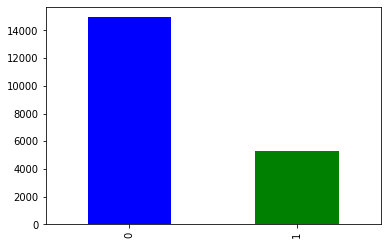

In [37]:
# Visualize Data
import matplotlib.pyplot as plt
Raw_Data_1['Sentiment_Classifier'].value_counts().plot(kind='bar' ,color=['blue', 'green', 'red'])

In [38]:
# Confirm if there is missing Data
print(Raw_Data_1.isnull().sum())

Customer_Comment        1
Sentiment_Classifier    0
dtype: int64


In [39]:
##This shows that there is at least one within Customer_Comment field, so let remove them.
Raw_Data_2 = Raw_Data_1[pd.notnull(Raw_Data_1["Customer_Comment"])]
Raw_Data_2.head()

,Customer_Comment,Sentiment_Classifier
0,Sai kha ya her kisi kay bus ki bat nhi hai lak...,0
1,sahi bt h,0
2,"Kya bt hai,",0
3,Wah je wah,0
4,Are wha kaya bat hai,0


In [40]:
# Confirm if there is missing Data
print(Raw_Data_2.isnull().sum())

Customer_Comment        0
Sentiment_Classifier    0
dtype: int64


In [41]:
# Convert data to lower case, trim leading and trailing white spaces.
# lower case
Raw_Data_2['Customer_Comment'] = Raw_Data_2['Customer_Comment'].str.lower()
Raw_Data_2.head(2)

,Customer_Comment,Sentiment_Classifier
0,sai kha ya her kisi kay bus ki bat nhi hai lak...,0
1,sahi bt h,0


In [42]:
#trim leading and trailing white spaces
Raw_Data_2 = Raw_Data_2.applymap(lambda x: x.strip() if isinstance(x, str) else x)
Raw_Data_2.head(2)

,Customer_Comment,Sentiment_Classifier
0,sai kha ya her kisi kay bus ki bat nhi hai lak...,0
1,sahi bt h,0


In [43]:
# Convert Sentiment_Classifier values to integers
Raw_Data_2['Sentiment_Classifier'] = Raw_Data_2.Sentiment_Classifier.astype('category').cat.codes
Raw_Data_2.head(2)

,Customer_Comment,Sentiment_Classifier
0,sai kha ya her kisi kay bus ki bat nhi hai lak...,0
1,sahi bt h,0


In [44]:
# For a deep learning model we need to know what the input sequence length for our model should be
# Calculate the number of words in the Customer_Comment column and find the maximum value to be used for input sequence

Raw_Data_2['num_words'] = Raw_Data_2.Customer_Comment.apply(lambda x : len(x.split()))

Raw_Data_2['num_words'].max()

301

In [45]:
# Set number of classes and target variable
num_class = len(np.unique(Raw_Data_2.Sentiment_Classifier.values))
y = Raw_Data_2['Sentiment_Classifier'].values
print(num_class)

2


In [46]:
#Tokenize the input and pad
maxlen = 302
tokenizer = tensorflow.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(Raw_Data_2.Customer_Comment.values)
post_seq = tokenizer.texts_to_sequences(Raw_Data_2.Customer_Comment.values)
post_seq_padded = pad_sequences(post_seq, maxlen=maxlen)

In [47]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

33269


In [48]:
# Creating a train test split with 30% in testing data set
x_train, x_test, y_train, y_test = train_test_split(post_seq_padded, y, test_size=0.30)

In [54]:
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

In [55]:
# Model
# Build Model
embedding_vector_length = 32 
model = Sequential() 
model.add(Embedding(vocab_size, 
                    embedding_vector_length, 
                    input_length = maxlen))
model.add(LSTM(256,return_sequences=True))
model.add(LSTM(128))
model.add(Dense(2, activation='sigmoid'))

In [56]:
# Compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 302, 32)           1064608   
                                                                 
 lstm_4 (LSTM)               (None, 302, 256)          295936    
                                                                 
 lstm_5 (LSTM)               (None, 128)               197120    
                                                                 
 dense_2 (Dense)             (None, 2)                 258       
                                                                 
Total params: 1,557,922
Trainable params: 1,557,922
Non-trainable params: 0
_________________________________________________________________
None


In [57]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5, batch_size=64)

Epoch 1/5
222/222 [==============================] - 42s 168ms/step - loss: 0.5141 - accuracy: 0.7579 - val_loss: 0.4504 - val_accuracy: 0.7825
Epoch 2/5
222/222 [==============================] - 36s 163ms/step - loss: 0.3035 - accuracy: 0.8719 - val_loss: 0.4704 - val_accuracy: 0.7909
Epoch 3/5
222/222 [==============================] - 36s 163ms/step - loss: 0.1524 - accuracy: 0.9424 - val_loss: 0.6382 - val_accuracy: 0.7906
Epoch 4/5
222/222 [==============================] - 36s 162ms/step - loss: 0.0838 - accuracy: 0.9714 - val_loss: 0.6456 - val_accuracy: 0.7622
Epoch 5/5
222/222 [==============================] - 36s 162ms/step - loss: 0.0584 - accuracy: 0.9794 - val_loss: 0.8693 - val_accuracy: 0.7881
